In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import operator

import warnings
warnings.filterwarnings("ignore")

# Take-Home Challenge: Relax Inc

<p>Relax Inc. makes productivity and project management software that's popular with both individuals and teams. Founded by several former Facebook employees, it's considered a great company to work at.</p>

##### Reading data

In [2]:
users_df = pd.read_csv("takehome_users.csv", encoding='latin_1', parse_dates=['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], origin='unix', unit='s')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [3]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [4]:
user_engagement_df = pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])
user_engagement_df['date'] = user_engagement_df['time_stamp'].dt.date
user_engagement_df.head()

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [5]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 4 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
date          207917 non-null object
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.3+ MB


## Problem Statement
<p>Adopted user: user who has logged into the product on three separate days in at least one seven-day period</p>
<p>Identify which factors predict future user adoption</p>

## Approach
1. Identify adopted users using current user engagement data
2. Train the classifier to identify whether user is adopted or not
3. Feature importance in the classifier model will be the solution

##### Identify adopted users using current user engagement data

In [6]:
engagement_df = user_engagement_df[['user_id','time_stamp','date']]
engagement_df = engagement_df.set_index(['user_id', 'time_stamp'])
engagement_df = engagement_df.sort_index()
engagement_df.head()

date
user_id time_stamp                     
1       2014-04-22 03:53:30  2014-04-22
2       2013-11-15 03:45:04  2013-11-15
        2013-11-29 03:45:04  2013-11-29
        2013-12-09 03:45:04  2013-12-09
        2013-12-25 03:45:04  2013-12-25

In [7]:
def has_logged_in(dates, times, window):
    times = times-1
    for i in np.arange(len(dates) - times):
        delta = dates[i + times] - dates[i]
        if delta.days <= window:
            return True
    return False

def is_adopted_user(row):
    if row.object_id in engagement_df.index:
        logins = engagement_df.loc[row.object_id].loc[row.creation_time:]
        dates = logins['date'].unique()
        if has_logged_in(dates, times=3, window=7):
            return 1
    return 0

def is_name_present_in_mail(row):
    return 1 if row.first_name in row.email or row.last_name in row.email else 0

In [8]:
users_df['is_adopted'] = users_df.apply(is_adopted_user, axis=1)
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [9]:
users_df.is_adopted.value_counts()

0    10344
1     1656
Name: is_adopted, dtype: int64

In [10]:
users_idf = users_df.set_index('object_id')
users_idf['first_name'] = users_idf['name'].str.split(' ', n=1, expand=True)[0]
users_idf['last_name'] = users_idf['name'].str.split(' ', n=1, expand=True)[1]
users_idf['name_email_match'] = users_idf.apply(is_name_present_in_mail, axis=1)
users_idf['is_invited'] = users_idf['invited_by_user_id'].notna().astype('int')
users_idf['mail_provider'] = users_idf['email'].str.split('@', n = 1, expand = True)[1]
users_idf['domain'] = users_idf['mail_provider'].str.split('.', n = 1, expand = True)[1]
users_idf.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted,first_name,last_name,name_email_match,is_invited,mail_provider,domain
object_id,,,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,Clausen,August,1,1,yahoo.com,com
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,Poole,Matthew,1,1,gustr.com,com
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,Bottrill,Mitchell,1,1,gustr.com,com
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,Clausen,Nicklas,1,1,yahoo.com,com
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,Raw,Grace,1,1,yahoo.com,com


##### Train the classifier to identify whether user is adopted or not

In [11]:
def preprocess(trainset, categories, features, target):
    dataset = trainset.copy()
    
    for column in categories:
        dataset[column] = dataset[column].astype('category')
    
    dataset = dataset[features]
    trainset = trainset[[target]].join(dataset)
    return trainset

In [12]:
features = ['creation_source', 'is_invited', 'name_email_match', 'mail_provider']
dataset = preprocess(users_idf, categories=features, features=features, target='is_adopted')
dataset.head()

,is_adopted,creation_source,is_invited,name_email_match,mail_provider
object_id,,,,,
1,0,GUEST_INVITE,1,1,yahoo.com
2,1,ORG_INVITE,1,1,gustr.com
3,0,ORG_INVITE,1,1,gustr.com
4,0,GUEST_INVITE,1,1,yahoo.com
5,0,GUEST_INVITE,1,1,yahoo.com


In [13]:
X_train, X_test = train_test_split(dataset, random_state=41, test_size=0.2)
X_train, X_val = train_test_split(X_train, random_state=41, test_size=0.25)
print("X_train : {}".format(X_train.shape))
print("X_val : {}".format(X_val.shape))
print("X_test : {}".format(X_test.shape))

X_train : (7200, 5)
X_val : (2400, 5)
X_test : (2400, 5)


In [14]:
def train(X_train, y_train, X_val, y_val, verbose):
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "boosting": "gbdt",
        "verbosity" : -1,
        "seed": 41,
        "early_stopping_round": 100
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_val, label=y_val)
    evals_result = {}
    model = lgb.train(params, lgtrain, 3000, valid_sets=[lgval], verbose_eval=verbose, evals_result=evals_result)
    score = evals_result['valid_0']['auc'][-1]
    
    return  model

In [15]:
def run_lgbm(X_train, X_val, X_test, features, target, verbose=False):
    X_train, y_train = X_train[features], X_train[target]
    X_val, y_val = X_val[features], X_val[target]
    X_test, y_test = X_test[features], X_test[target]
    
    model = train(X_train, y_train, X_val, y_val, verbose)
    
    score1 = roc_auc_score(y_train, model.predict(X_train))
    score2 = roc_auc_score(y_val, model.predict(X_val))
    score3 = roc_auc_score(y_test, model.predict(X_test))
    
    return model, score1, score2, score3

In [16]:
model, train_score, val_score, test_score = run_lgbm(X_train, X_val, X_test, features=features, target='is_adopted')
train_score, val_score, test_score

(0.599767399452684, 0.5807402095990142, 0.5593182611473635)

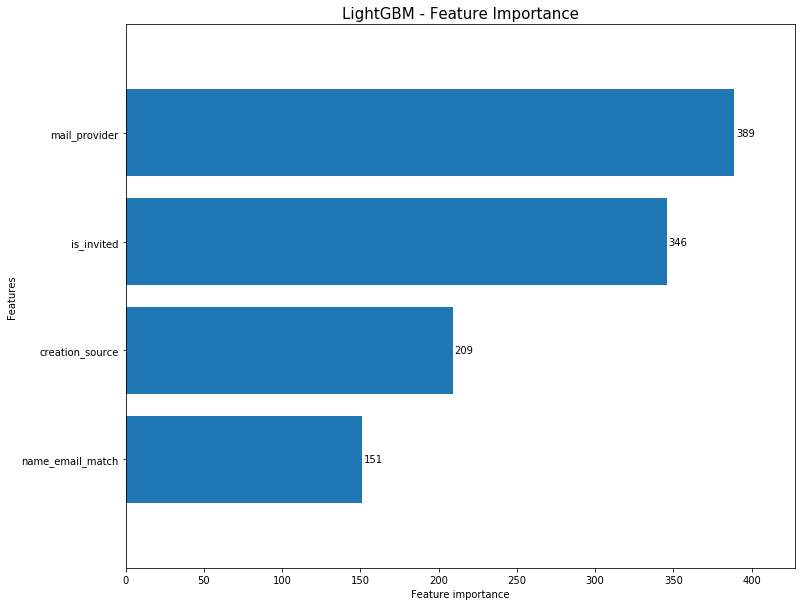

In [17]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## Solution

The below factors can predict the future user adoption
1. Email Service Provider that user is using to access the product
2. Whether user is invited by another user or not
3. Source of User account creation
4. Whehter email address is format or casual